## Climate indicator comparisons

In [2]:
# %matplotlib qt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr
import matplotlib.lines as mlines

IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [3]:
obs = pd.read_csv(IOPATH)
obs

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),...,Ni (nmol kg-1),Zn (nmol kg-1),source,current,location,[TA-DIC] (uM),year,month,NSdist,EWdist
0,0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
1,1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
2,2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
3,3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
4,4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722329,1722329,1722329,1805040,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,377.942065,NaN
1722330,1722330,1722330,1805041,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,377.942065,NaN
1722331,1722331,1722331,1805042,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,133.256480,-0.0
1722332,1722332,1722332,1805043,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,133.256480,-0.0


In [4]:
pd.unique(obs['current'])

array(['shelf', nan, 'CUC', 'CC'], dtype=object)

In [5]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

In [6]:
# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

/tmp/ipykernel_2418678/497193821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_cuc['dist'] = obs_cuc.NSdist
/tmp/ipykernel_2418678/497193821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_shelf['dist'] = obs_shelf.NSdist
/tmp/ipykernel_2418678/497193821.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

### Where I got climate indicators from:

Originally from my research with Rich which can be found in /ocean/ghoeven/Atlas/Climatology2024

enso.csv 
https://psl.noaa.gov/enso/mei/

npgo.csv 
http://www.o3d.org/npgo/

pdo.csv
https://www.ncei.noaa.gov/access/monitoring/pdo/

bifurcation_index.csv
https://github.com/michaelmalick/bifurcation-index?utm_source=chatgpt.com


In [7]:
# Loading in Climate Indicators

def add_time_and_decimal_year(df, year_col="year", month_col="month"):
    df = df.copy()
    df["day"] = 1
    df["time"] = pd.to_datetime(df[[year_col, month_col, "day"]])

    start_of_year = pd.to_datetime(df[year_col].astype(str) + "-01-01")
    end_of_year   = pd.to_datetime((df[year_col] + 1).astype(str) + "-01-01")
    df["decimal_yr"] = df[year_col] + (df["time"] - start_of_year) / (end_of_year - start_of_year)
    return df

def annual_mean_from_monthly(df, year_col="year", index_col="index", year_time="start"):
    """
    year_time:
      - "start" -> time = YYYY-01-01
      - "mid"   -> time = YYYY-07-01 (often nicer for plotting)
    """
    ann = (
        df.groupby(year_col, as_index=False)[index_col]
          .mean()
          .rename(columns={index_col: "index"})
    )

    if year_time == "mid":
        ann["time"] = pd.to_datetime(ann[year_col].astype(str) + "-07-01")
        ann["decimal_yr"] = ann[year_col] + 0.5
    else:
        ann["time"] = pd.to_datetime(ann[year_col].astype(str) + "-01-01")
        ann["decimal_yr"] = ann[year_col].astype(float)

    return ann


# ------
# ENSO
# ------
enso = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/enso1979.csv",
    names=["year"] + [str(x + 1) for x in range(12)]
)

enso = enso.melt(id_vars="year", var_name="month", value_name="index")
enso["month"] = enso["month"].astype(int)
enso = enso.sort_values(["year", "month"]).reset_index(drop=True)
enso = add_time_and_decimal_year(enso)

enso_ann = annual_mean_from_monthly(enso, year_time="mid")


# ------
# NPGO
# ------
npgo = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/npgo1950.csv",
    names=["year", "month", "index"]
)

npgo = npgo.sort_values(["year", "month"]).reset_index(drop=True)
npgo = add_time_and_decimal_year(npgo)

npgo_ann = annual_mean_from_monthly(npgo, year_time="mid")  # or "mid"


# ------
# PDO
# ------
pdo = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/pdo1854.csv",
    names=["year"] + [str(x + 1) for x in range(12)]
)

pdo = pdo.melt(id_vars="year", var_name="month", value_name="index")
pdo["month"] = pdo["month"].astype(int)
pdo = pdo.sort_values(["year", "month"]).reset_index(drop=True)
pdo = add_time_and_decimal_year(pdo)

pdo_ann = annual_mean_from_monthly(pdo, year_time="mid")  # or "mid"


# ------
# BI
# ------
bi = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/bifurcation_index.csv",
    header=11,names=["year","index"],
)

## Functions

In [17]:
# ---------- helpers ----------
def _ensure_numeric(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _bin_depth(depth_series, depth_edges): # not necessarily just for depth, can bin anything
    return pd.cut(depth_series, bins=depth_edges, right=False,
                  include_lowest=True, labels=False)

# ---------- statistics ----------
def monthly_anom_to_annual_after_lag(anom_1d, t_month, *, lag_months=0,
                                    annual_stat="mean", min_months_per_year=6):
    """
    anom_1d : (ntime,) monthly anomaly series for one bin
    t_month : (ntime,) decimal years at start of month (year + (month-1)/12)

    Returns
    -------
    anom_ann : (nyears,)
    t_year   : (nyears,) decimal years at Jan 1 (integers as float)
    """
    anom_1d = np.asarray(anom_1d, float)
    t_shift = np.asarray(t_month, float) + lag_months / 12.0

    year_label = np.floor(t_shift).astype(int)
    years = np.arange(year_label.min(), year_label.max() + 1)

    anom_ann = np.full(years.shape, np.nan, dtype=float)

    for j, y in enumerate(years):
        cols = np.where(year_label == y)[0]
        if cols.size == 0:
            continue
        x = anom_1d[cols]
        n_valid = np.sum(~np.isnan(x))
        if n_valid < min_months_per_year:
            continue
        if annual_stat == "median":
            anom_ann[j] = np.nanmedian(x)
        else:
            anom_ann[j] = np.nanmean(x)

    t_year = years.astype(float)
    return anom_ann, t_year

def _calc_stats_annual(anom_1d_monthly, t_month, df2_ann, *, lag_months=0,
                       min_months_per_year=9, year_tolerance=0):
    # 1) lag monthly anomalies, then annualize
    anom_ann, t_year = monthly_anom_to_annual_after_lag(
        anom_1d_monthly, t_month,
        lag_months=lag_months,
        annual_stat="mean",
        min_months_per_year=min_months_per_year
    )

    # 2) annual index series
    idx_series = pd.Series(df2_ann["index"].to_numpy(), index=df2_ann["year"].to_numpy().astype(float))
    anom_series = pd.Series(anom_ann, index=t_year)

    # 3) align (years should match exactly; tolerance optional)
    if year_tolerance == 0:
        idx_aligned = idx_series.reindex(anom_series.index)
    else:
        idx_aligned = idx_series.reindex(anom_series.index, method="nearest", tolerance=year_tolerance)

    mask = ~idx_aligned.isna() & ~anom_series.isna()
    n = int(mask.sum())
    if n < 3:
        return {"r": np.nan, "pvalue": np.nan, "n": n}

    r = pearsonr(anom_series[mask].values, idx_aligned[mask].values)
    return {"r": r.statistic, "pvalue": r.pvalue, "n": n}

def _find_best_lag(anom_1d_monthly, t_month, df2_ann, max_lag_months=6,
                          min_months_per_year=9):
    r_by_lag, p_by_lag, n_by_lag = [], [], []

    for k in range(int(max_lag_months) + 1):
        stats = _calc_stats_annual(
            anom_1d_monthly, t_month, df2_ann,
            lag_months=k, min_months_per_year=min_months_per_year
        )
        r_by_lag.append(stats["r"])
        p_by_lag.append(stats["pvalue"])
        n_by_lag.append(stats["n"])

    r_arr = np.asarray(r_by_lag, float)
    if np.all(np.isnan(r_arr)):
        return {"best_lag_months": np.nan, "r": np.nan, "pvalue": np.nan, "n": 0}

    kbest = int(np.nanargmax(np.abs(r_arr)))
    return {"best_lag_months": kbest, "r": r_arr[kbest], "pvalue": p_by_lag[kbest], "n": n_by_lag[kbest]}


# ---------- monthly lat-binned means ----------
def avg_profile_12months_dist(obs_used, dist_edges, variable_str, return_counts=False):
    s = _ensure_numeric(obs_used, [variable_str, 'latitude (degrees_north)', 'month'])
    s = s.dropna(subset=[variable_str, 'latitude (degrees_north)', 'month']).copy()
    s['_month'] = s['month'].astype(int)
    s['_zbin'] = _bin_depth(s['latitude (degrees_north)'], dist_edges)

    g = s.groupby(['_month', '_zbin'])[variable_str].agg(['mean', 'count'])
    nbins = len(dist_edges) - 1
    mean_arr = np.full((12, nbins), np.nan)
    cnt_arr = np.zeros((12, nbins), dtype=int)

    if not g.empty:
        idx = g.index.to_frame(index=False)
        m_ix = idx['_month'].to_numpy() - 1
        z_ix = idx['_zbin'].astype(int).to_numpy()
        mean_arr[m_ix, z_ix] = g['mean'].to_numpy()
        cnt_arr[m_ix, z_ix] = g['count'].to_numpy()

    return (mean_arr, cnt_arr) if return_counts else mean_arr

def contour_prep_dist_monthly(obs_used, start_yr, end_yr, dist_edges,
                               variable_str, base_period=None, min_samples_per_cell=3):
    years = np.arange(int(start_yr), int(end_yr) + 1)
    nyears = len(years)
    nbins = len(dist_edges) - 1

    # climatology base period
    if base_period is not None:
        by0, by1 = base_period
        clim_obs = obs_used[(obs_used['year'] >= by0) & (obs_used['year'] <= by1)]
    else:
        clim_obs = obs_used

    clim_mean, clim_cnt = avg_profile_12months_dist(clim_obs, dist_edges,
                                                     variable_str, return_counts=True)

    yr_month_means = []
    yr_month_counts = []
    for yr in years:
        m12, c12 = avg_profile_12months_dist(
            obs_used[obs_used['year'] == yr], dist_edges, variable_str, return_counts=True)
        yr_month_means.append(m12)
        yr_month_counts.append(c12)

    yr_means = np.vstack(yr_month_means)
    yr_counts = np.vstack(yr_month_counts)
    clim_tiled = np.tile(clim_mean, (nyears, 1))

    anom = (yr_means - clim_tiled).T
    mask = (yr_counts.T >= min_samples_per_cell)
    anom[~mask] = np.nan

    months = np.tile(np.arange(1, 13), nyears)
    years_rep = np.repeat(years, 12)
    t_month = years_rep + (months - 1) / 12.0 # t_month at start of month to align with dates we set for climate indices
    return anom, t_month



## Latitude Anomaly Plots

In [14]:
# --------------------------
# plotting helpers (annual)
# --------------------------
def plot_panel_annual(ax, anom_1d_monthly, t_month, df2_ann,
                      max_lag_months=6, colour='k', xloc=0, yloc=0.82,
                      min_months_per_year=9):
    """
    Annotate best lag (0..max_lag_months) computed by:
      lag monthly anomalies -> annual mean -> correlate with annual index
    """
    best = _find_best_lag_annual(
        anom_1d_monthly, t_month, df2_ann,
        max_lag_months=max_lag_months,
        min_months_per_year=min_months_per_year
    )

    statstext = (f"Lag = {best['best_lag_months']} mo, n = {best['n']}\n"
                 f"r = {best['r']:.2f}  (p = {best['pvalue']:.3f})")

    props = dict(boxstyle='round', facecolor='w', edgecolor=colour, alpha=0.7)
    return ax.text(xloc, yloc, statstext, bbox=props, transform=ax.transAxes, fontsize=9)


def annualize_for_plot(anom_1d_monthly, t_month, *, lag_months=0, min_months_per_year=9):
    """
    Convenience wrapper for plotting: annual mean anomaly after optional lag.
    """
    anom_ann, t_year = monthly_anom_to_annual_after_lag(
        anom_1d_monthly, t_month,
        lag_months=lag_months,
        annual_stat="mean",
        min_months_per_year=min_months_per_year
    )
    return t_year, anom_ann

### Temperature

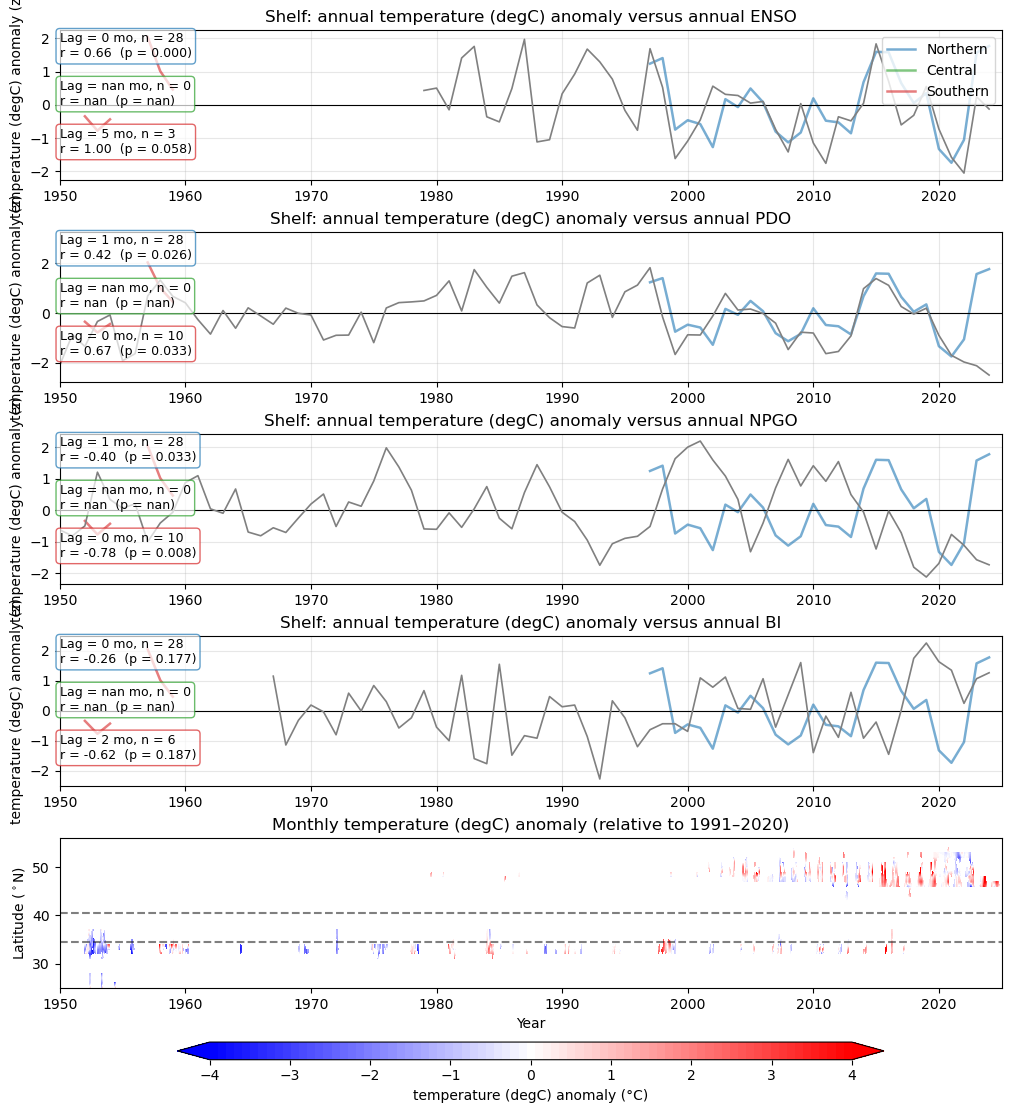

In [27]:

obs_used = obs_shelf.copy()
variable_str = 'temperature (degC)'

start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))

max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])

dist_edges1 = [min_dist-0.1, 34.45, 40.44, max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

base_period = (1991, 2020)

# monthly anomalies needed for month-lagging
anom_monthly_1, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(5, 1, figsize=(10, 11), constrained_layout=True)

indices_name = ['ENSO', 'PDO', 'NPGO', 'BI']
indices_ann  = [enso_ann, pdo_ann, npgo_ann, bi]   # <- annual mean indices (must exist)

# ---- top 3 panels: annual anomalies vs annual indices, but lag in months ----
for i in range(4):
    df2_ann = indices_ann[i]

    # annualize each regional anomaly series for plotting (no lag here; lag is reported in box)
    t_year, north_ann = annualize_for_plot(anom_monthly_1[2], t_month, lag_months=0, min_months_per_year=9)
    _,      cent_ann  = annualize_for_plot(anom_monthly_1[1], t_month, lag_months=0, min_months_per_year=9)
    _,      south_ann = annualize_for_plot(anom_monthly_1[0], t_month, lag_months=0, min_months_per_year=9)

    ax[i].plot(t_year, zscore(north_ann, nan_policy='omit'),
               color='tab:blue', lw=1.8, alpha=0.6, label='Northern')
    ax[i].plot(t_year, zscore(cent_ann, nan_policy='omit'),
               color='tab:green', lw=1.8, alpha=0.6, label='Central')
    ax[i].plot(t_year, zscore(south_ann, nan_policy='omit'),
               color='tab:red', lw=1.8, alpha=0.6, label='Southern')

    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel(f'{variable_str} anomaly (z)')
    ax[i].set_title(f"Shelf: annual {variable_str} anomaly versus annual {indices_name[i]}")

    # stats boxes (best month-lag, computed on annualized anomalies)
    plot_panel_annual(ax[i], anom_monthly_1[2], t_month, df2_ann,
                      max_lag_months=6, colour='tab:blue', xloc=0, yloc=0.82, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[1], t_month, df2_ann,
                      max_lag_months=6, colour='tab:green', xloc=0, yloc=0.50, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[0], t_month, df2_ann,
                      max_lag_months=6, colour='tab:red', xloc=0, yloc=0.18, min_months_per_year=9)

    # plot annual index (also z-scored to match)
    ax[i].plot(df2_ann['year'].to_numpy(),
               zscore(df2_ann['index'].to_numpy(), nan_policy='omit'),
               color='gray', lw=1.2)

ax[0].legend(loc='upper right')


# ---- bottom panel: keep monthly latitude–time contour (still monthly anomalies) ----
anom_monthly_2, t_month2 = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month2, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[4].contourf(X, Y, anom_monthly_2, levels=levels, cmap='bwr', extend='both')

ax[4].set_xlim(start_yr, end_yr + 1)
ax[4].set_xlabel('Year')
ax[4].set_ylabel('Latitude ($^\\circ$N)')
ax[4].plot([start_yr, end_yr + 1], [34.45, 34.45], 'k--', alpha=0.5)
ax[4].plot([start_yr, end_yr + 1], [40.44, 40.44], 'k--', alpha=0.5)
ax[4].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f'{variable_str} anomaly (°C)')


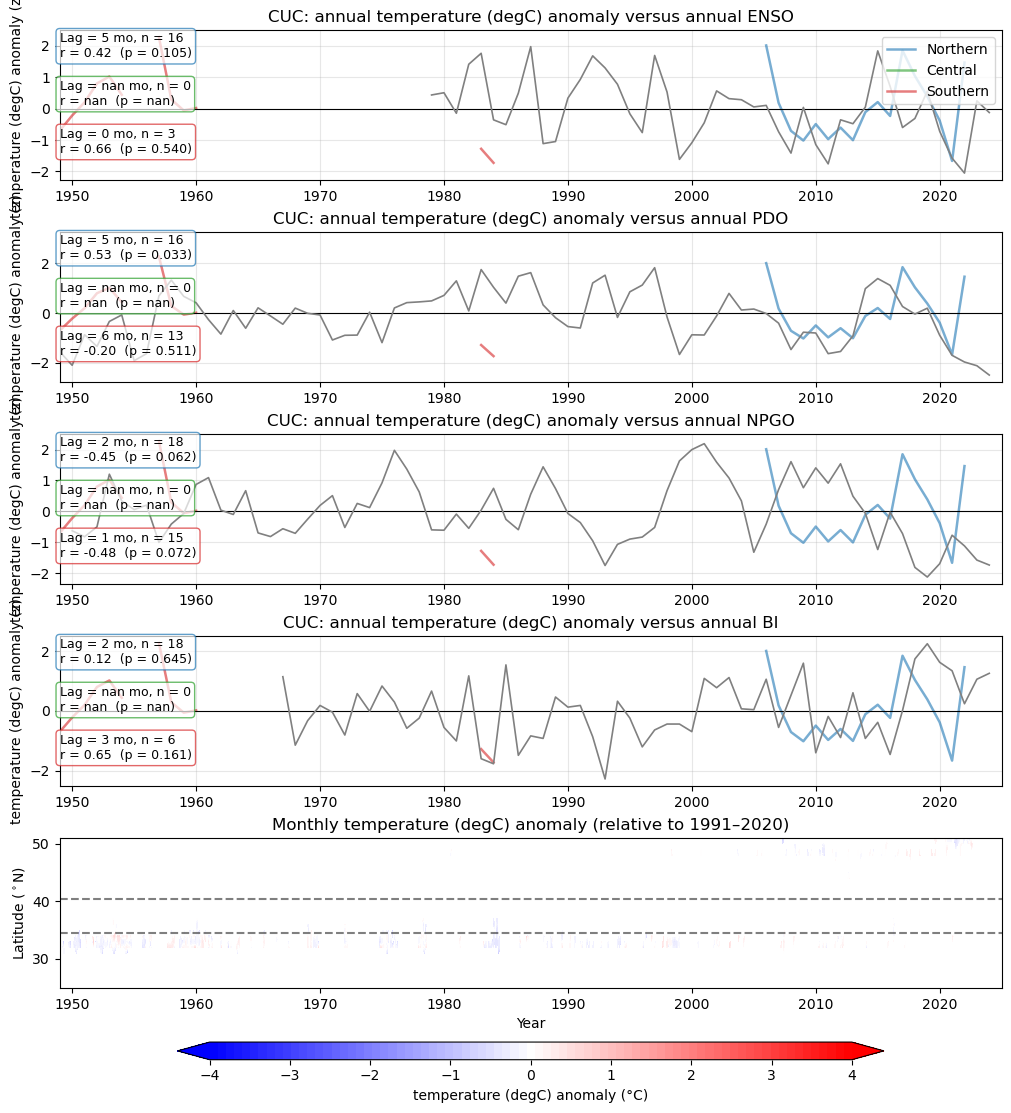

In [31]:

obs_used = obs_cuc.copy()
variable_str = 'temperature (degC)'

start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))

max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])

dist_edges1 = [min_dist-0.1, 34.45, 40.44, max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

base_period = (1991, 2020)

# monthly anomalies needed for month-lagging
anom_monthly_1, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(5, 1, figsize=(10, 11), constrained_layout=True)

indices_name = ['ENSO', 'PDO', 'NPGO', 'BI']
indices_ann  = [enso_ann, pdo_ann, npgo_ann, bi]   # <- annual mean indices (must exist)

# ---- top 3 panels: annual anomalies vs annual indices, but lag in months ----
for i in range(4):
    df2_ann = indices_ann[i]

    # annualize each regional anomaly series for plotting (no lag here; lag is reported in box)
    t_year, north_ann = annualize_for_plot(anom_monthly_1[2], t_month, lag_months=0, min_months_per_year=9)
    _,      cent_ann  = annualize_for_plot(anom_monthly_1[1], t_month, lag_months=0, min_months_per_year=9)
    _,      south_ann = annualize_for_plot(anom_monthly_1[0], t_month, lag_months=0, min_months_per_year=9)

    ax[i].plot(t_year, zscore(north_ann, nan_policy='omit'),
               color='tab:blue', lw=1.8, alpha=0.6, label='Northern')
    ax[i].plot(t_year, zscore(cent_ann, nan_policy='omit'),
               color='tab:green', lw=1.8, alpha=0.6, label='Central')
    ax[i].plot(t_year, zscore(south_ann, nan_policy='omit'),
               color='tab:red', lw=1.8, alpha=0.6, label='Southern')

    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel(f'{variable_str} anomaly (z)')
    ax[i].set_title(f"CUC: annual {variable_str} anomaly versus annual {indices_name[i]}")

    # stats boxes (best month-lag, computed on annualized anomalies)
    plot_panel_annual(ax[i], anom_monthly_1[2], t_month, df2_ann,
                      max_lag_months=6, colour='tab:blue', xloc=0, yloc=0.82, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[1], t_month, df2_ann,
                      max_lag_months=6, colour='tab:green', xloc=0, yloc=0.50, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[0], t_month, df2_ann,
                      max_lag_months=6, colour='tab:red', xloc=0, yloc=0.18, min_months_per_year=9)

    # plot annual index (also z-scored to match)
    ax[i].plot(df2_ann['year'].to_numpy(),
               zscore(df2_ann['index'].to_numpy(), nan_policy='omit'),
               color='gray', lw=1.2)

ax[0].legend(loc='upper right')


# ---- bottom panel: keep monthly latitude–time contour (still monthly anomalies) ----
anom_monthly_2, t_month2 = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month2, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[4].contourf(X, Y, anom_monthly_2, levels=levels, cmap='bwr', extend='both')

ax[4].set_xlim(start_yr, end_yr + 1)
ax[4].set_xlabel('Year')
ax[4].set_ylabel('Latitude ($^\\circ$N)')
ax[4].plot([start_yr, end_yr + 1], [34.45, 34.45], 'k--', alpha=0.5)
ax[4].plot([start_yr, end_yr + 1], [40.44, 40.44], 'k--', alpha=0.5)
ax[4].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f'{variable_str} anomaly (°C)')


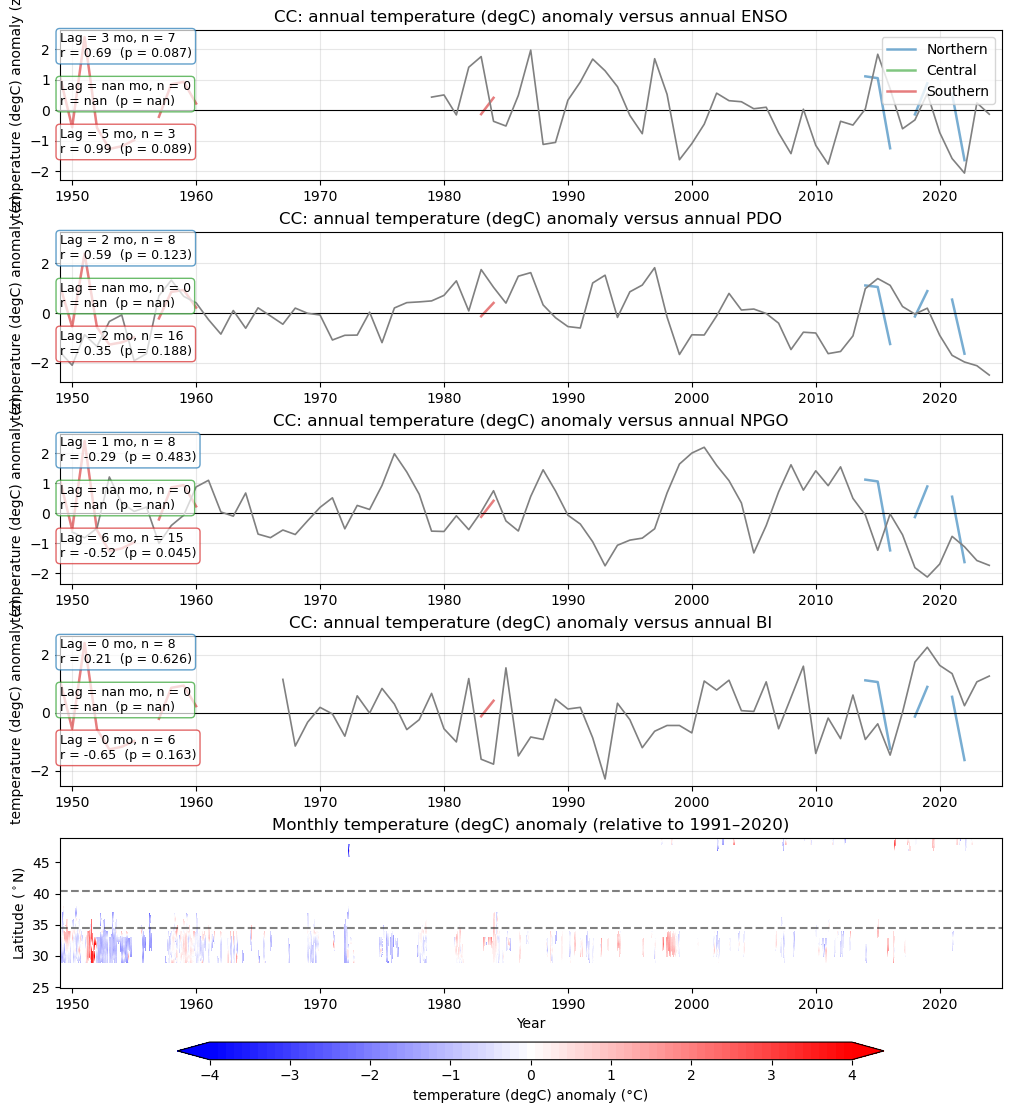

In [32]:

obs_used = obs_cc.copy()
variable_str = 'temperature (degC)'

start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))

max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])

dist_edges1 = [min_dist-0.1, 34.45, 40.44, max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

base_period = (1991, 2020)

# monthly anomalies needed for month-lagging
anom_monthly_1, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(5, 1, figsize=(10, 11), constrained_layout=True)

indices_name = ['ENSO', 'PDO', 'NPGO', 'BI']
indices_ann  = [enso_ann, pdo_ann, npgo_ann, bi]   # <- annual mean indices (must exist)

# ---- top 3 panels: annual anomalies vs annual indices, but lag in months ----
for i in range(4):
    df2_ann = indices_ann[i]

    # annualize each regional anomaly series for plotting (no lag here; lag is reported in box)
    t_year, north_ann = annualize_for_plot(anom_monthly_1[2], t_month, lag_months=0, min_months_per_year=9)
    _,      cent_ann  = annualize_for_plot(anom_monthly_1[1], t_month, lag_months=0, min_months_per_year=9)
    _,      south_ann = annualize_for_plot(anom_monthly_1[0], t_month, lag_months=0, min_months_per_year=9)

    ax[i].plot(t_year, zscore(north_ann, nan_policy='omit'),
               color='tab:blue', lw=1.8, alpha=0.6, label='Northern')
    ax[i].plot(t_year, zscore(cent_ann, nan_policy='omit'),
               color='tab:green', lw=1.8, alpha=0.6, label='Central')
    ax[i].plot(t_year, zscore(south_ann, nan_policy='omit'),
               color='tab:red', lw=1.8, alpha=0.6, label='Southern')

    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel(f'{variable_str} anomaly (z)')
    ax[i].set_title(f"CC: annual {variable_str} anomaly versus annual {indices_name[i]}")

    # stats boxes (best month-lag, computed on annualized anomalies)
    plot_panel_annual(ax[i], anom_monthly_1[2], t_month, df2_ann,
                      max_lag_months=6, colour='tab:blue', xloc=0, yloc=0.82, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[1], t_month, df2_ann,
                      max_lag_months=6, colour='tab:green', xloc=0, yloc=0.50, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[0], t_month, df2_ann,
                      max_lag_months=6, colour='tab:red', xloc=0, yloc=0.18, min_months_per_year=9)

    # plot annual index (also z-scored to match)
    ax[i].plot(df2_ann['year'].to_numpy(),
               zscore(df2_ann['index'].to_numpy(), nan_policy='omit'),
               color='gray', lw=1.2)

ax[0].legend(loc='upper right')


# ---- bottom panel: keep monthly latitude–time contour (still monthly anomalies) ----
anom_monthly_2, t_month2 = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month2, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[4].contourf(X, Y, anom_monthly_2, levels=levels, cmap='bwr', extend='both')

ax[4].set_xlim(start_yr, end_yr + 1)
ax[4].set_xlabel('Year')
ax[4].set_ylabel('Latitude ($^\\circ$N)')
ax[4].plot([start_yr, end_yr + 1], [34.45, 34.45], 'k--', alpha=0.5)
ax[4].plot([start_yr, end_yr + 1], [40.44, 40.44], 'k--', alpha=0.5)
ax[4].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f'{variable_str} anomaly (°C)')


### Salinity

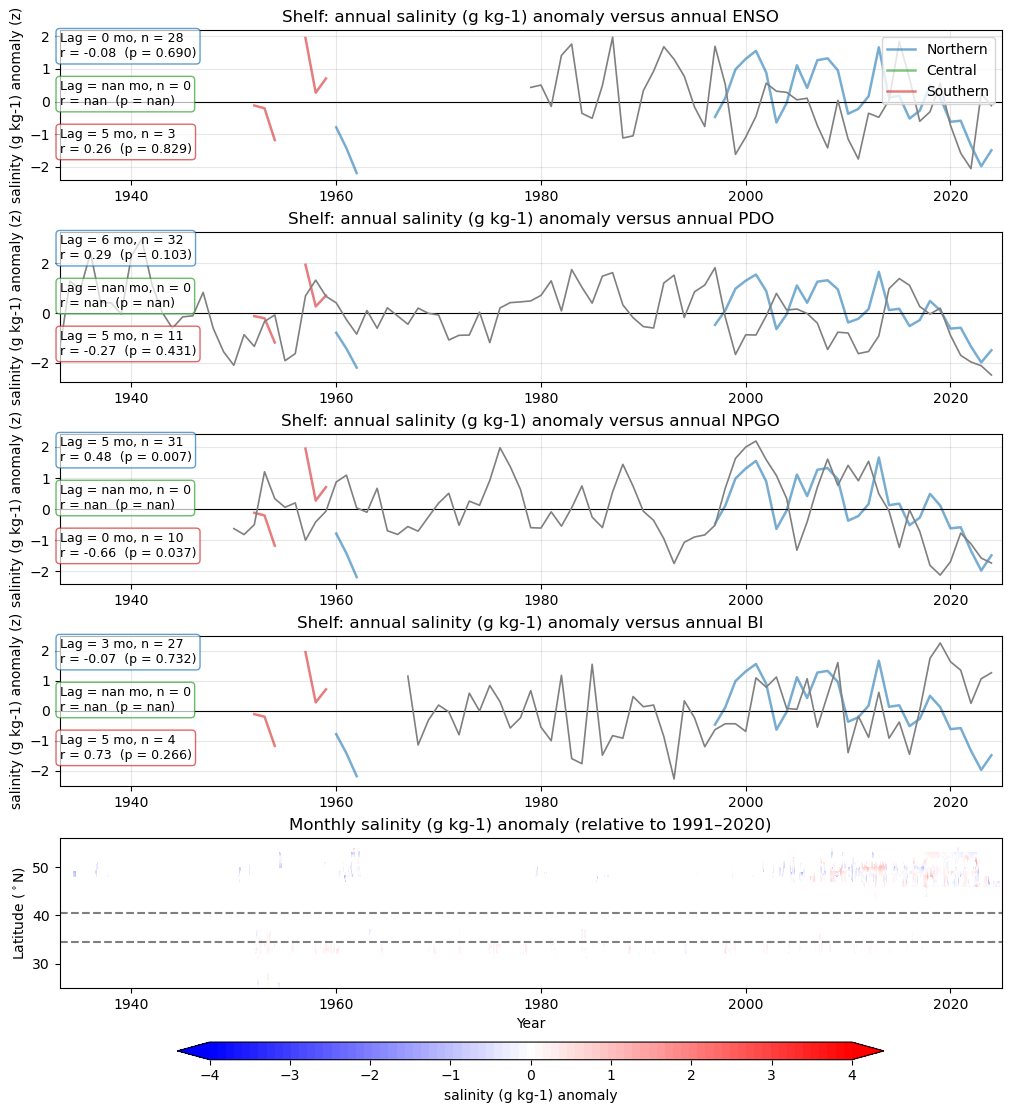

In [33]:

obs_used = obs_shelf.copy()
variable_str = 'salinity (g kg-1)'

start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))

max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])

dist_edges1 = [min_dist-0.1, 34.45, 40.44, max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

base_period = (1991, 2020)

# monthly anomalies needed for month-lagging
anom_monthly_1, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(5, 1, figsize=(10, 11), constrained_layout=True)

indices_name = ['ENSO', 'PDO', 'NPGO', 'BI']
indices_ann  = [enso_ann, pdo_ann, npgo_ann, bi]   # <- annual mean indices (must exist)

# ---- top 3 panels: annual anomalies vs annual indices, but lag in months ----
for i in range(4):
    df2_ann = indices_ann[i]

    # annualize each regional anomaly series for plotting (no lag here; lag is reported in box)
    t_year, north_ann = annualize_for_plot(anom_monthly_1[2], t_month, lag_months=0, min_months_per_year=9)
    _,      cent_ann  = annualize_for_plot(anom_monthly_1[1], t_month, lag_months=0, min_months_per_year=9)
    _,      south_ann = annualize_for_plot(anom_monthly_1[0], t_month, lag_months=0, min_months_per_year=9)

    ax[i].plot(t_year, zscore(north_ann, nan_policy='omit'),
               color='tab:blue', lw=1.8, alpha=0.6, label='Northern')
    ax[i].plot(t_year, zscore(cent_ann, nan_policy='omit'),
               color='tab:green', lw=1.8, alpha=0.6, label='Central')
    ax[i].plot(t_year, zscore(south_ann, nan_policy='omit'),
               color='tab:red', lw=1.8, alpha=0.6, label='Southern')

    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel(f'{variable_str} anomaly (z)')
    ax[i].set_title(f"Shelf: annual {variable_str} anomaly versus annual {indices_name[i]}")

    # stats boxes (best month-lag, computed on annualized anomalies)
    plot_panel_annual(ax[i], anom_monthly_1[2], t_month, df2_ann,
                      max_lag_months=6, colour='tab:blue', xloc=0, yloc=0.82, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[1], t_month, df2_ann,
                      max_lag_months=6, colour='tab:green', xloc=0, yloc=0.50, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[0], t_month, df2_ann,
                      max_lag_months=6, colour='tab:red', xloc=0, yloc=0.18, min_months_per_year=9)

    # plot annual index (also z-scored to match)
    ax[i].plot(df2_ann['year'].to_numpy(),
               zscore(df2_ann['index'].to_numpy(), nan_policy='omit'),
               color='gray', lw=1.2)

ax[0].legend(loc='upper right')


# ---- bottom panel: keep monthly latitude–time contour (still monthly anomalies) ----
anom_monthly_2, t_month2 = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month2, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[4].contourf(X, Y, anom_monthly_2, levels=levels, cmap='bwr', extend='both')

ax[4].set_xlim(start_yr, end_yr + 1)
ax[4].set_xlabel('Year')
ax[4].set_ylabel('Latitude ($^\\circ$N)')
ax[4].plot([start_yr, end_yr + 1], [34.45, 34.45], 'k--', alpha=0.5)
ax[4].plot([start_yr, end_yr + 1], [40.44, 40.44], 'k--', alpha=0.5)
ax[4].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f'{variable_str} anomaly')


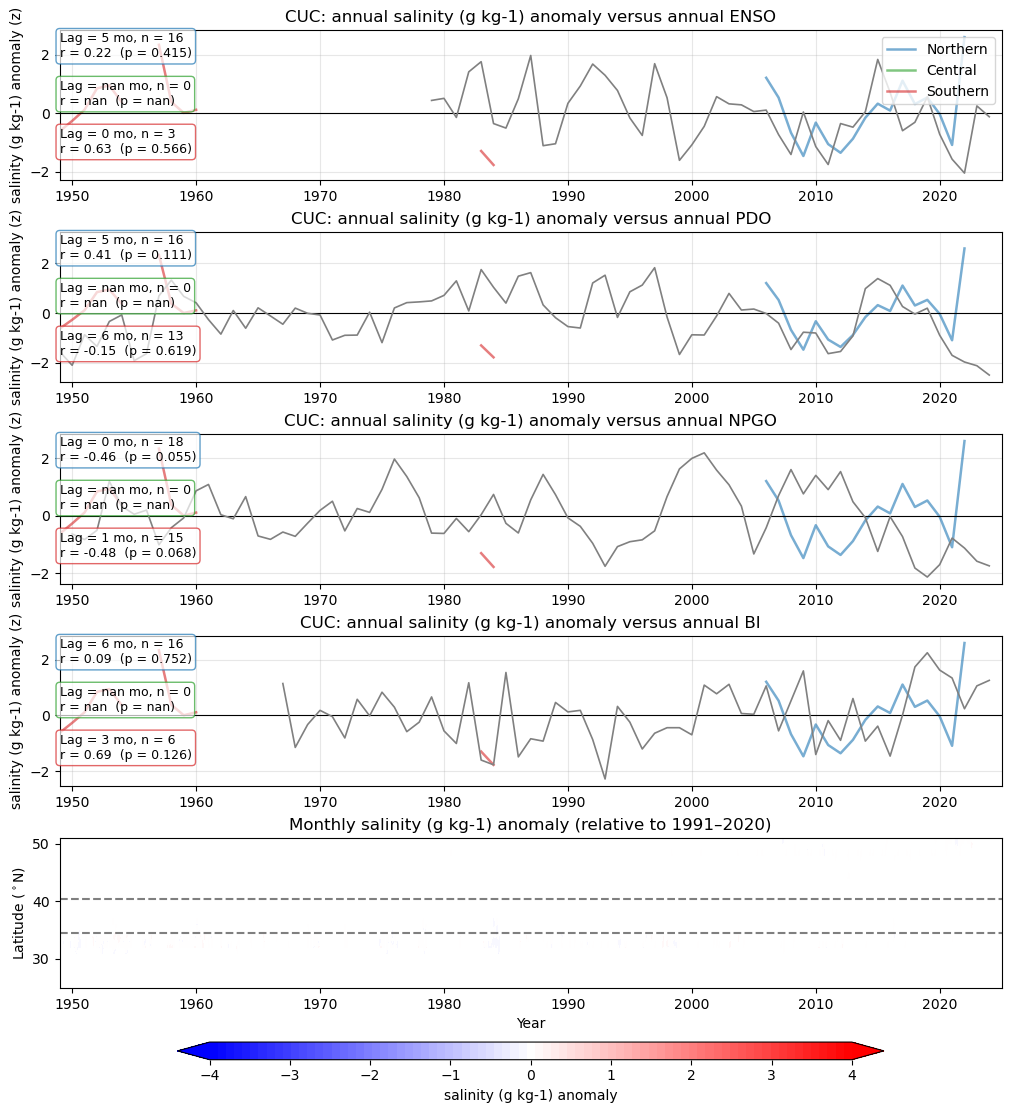

In [34]:

obs_used = obs_cuc.copy()
variable_str = 'salinity (g kg-1)'

start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))

max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])

dist_edges1 = [min_dist-0.1, 34.45, 40.44, max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

base_period = (1991, 2020)

# monthly anomalies needed for month-lagging
anom_monthly_1, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(5, 1, figsize=(10, 11), constrained_layout=True)

indices_name = ['ENSO', 'PDO', 'NPGO', 'BI']
indices_ann  = [enso_ann, pdo_ann, npgo_ann, bi]   # <- annual mean indices (must exist)

# ---- top 3 panels: annual anomalies vs annual indices, but lag in months ----
for i in range(4):
    df2_ann = indices_ann[i]

    # annualize each regional anomaly series for plotting (no lag here; lag is reported in box)
    t_year, north_ann = annualize_for_plot(anom_monthly_1[2], t_month, lag_months=0, min_months_per_year=9)
    _,      cent_ann  = annualize_for_plot(anom_monthly_1[1], t_month, lag_months=0, min_months_per_year=9)
    _,      south_ann = annualize_for_plot(anom_monthly_1[0], t_month, lag_months=0, min_months_per_year=9)

    ax[i].plot(t_year, zscore(north_ann, nan_policy='omit'),
               color='tab:blue', lw=1.8, alpha=0.6, label='Northern')
    ax[i].plot(t_year, zscore(cent_ann, nan_policy='omit'),
               color='tab:green', lw=1.8, alpha=0.6, label='Central')
    ax[i].plot(t_year, zscore(south_ann, nan_policy='omit'),
               color='tab:red', lw=1.8, alpha=0.6, label='Southern')

    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel(f'{variable_str} anomaly (z)')
    ax[i].set_title(f"CUC: annual {variable_str} anomaly versus annual {indices_name[i]}")

    # stats boxes (best month-lag, computed on annualized anomalies)
    plot_panel_annual(ax[i], anom_monthly_1[2], t_month, df2_ann,
                      max_lag_months=6, colour='tab:blue', xloc=0, yloc=0.82, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[1], t_month, df2_ann,
                      max_lag_months=6, colour='tab:green', xloc=0, yloc=0.50, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[0], t_month, df2_ann,
                      max_lag_months=6, colour='tab:red', xloc=0, yloc=0.18, min_months_per_year=9)

    # plot annual index (also z-scored to match)
    ax[i].plot(df2_ann['year'].to_numpy(),
               zscore(df2_ann['index'].to_numpy(), nan_policy='omit'),
               color='gray', lw=1.2)

ax[0].legend(loc='upper right')


# ---- bottom panel: keep monthly latitude–time contour (still monthly anomalies) ----
anom_monthly_2, t_month2 = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month2, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[4].contourf(X, Y, anom_monthly_2, levels=levels, cmap='bwr', extend='both')

ax[4].set_xlim(start_yr, end_yr + 1)
ax[4].set_xlabel('Year')
ax[4].set_ylabel('Latitude ($^\\circ$N)')
ax[4].plot([start_yr, end_yr + 1], [34.45, 34.45], 'k--', alpha=0.5)
ax[4].plot([start_yr, end_yr + 1], [40.44, 40.44], 'k--', alpha=0.5)
ax[4].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f'{variable_str} anomaly')


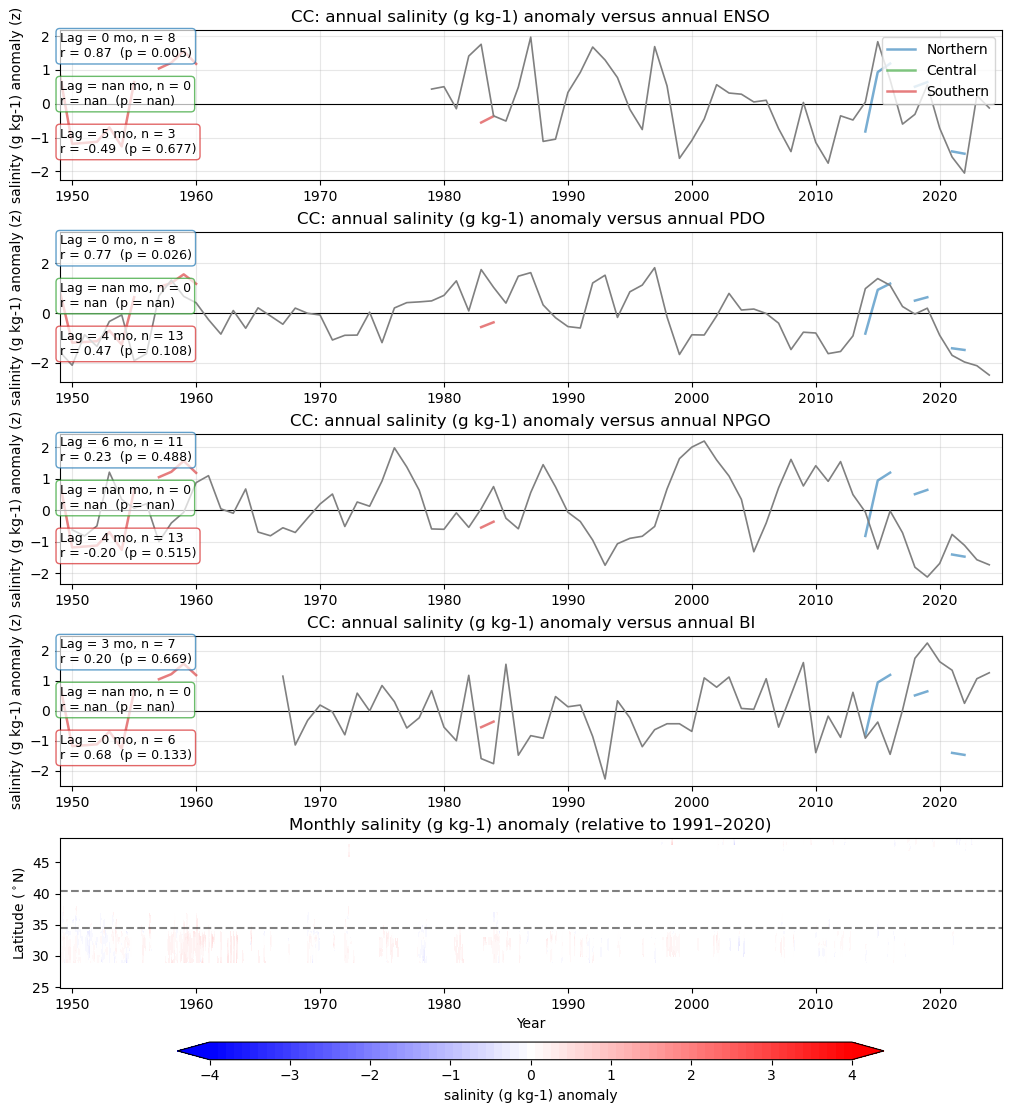

In [35]:

obs_used = obs_cc.copy()
variable_str = 'salinity (g kg-1)'

start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))

max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])

dist_edges1 = [min_dist-0.1, 34.45, 40.44, max_dist+0.1]
dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

base_period = (1991, 2020)

# monthly anomalies needed for month-lagging
anom_monthly_1, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(5, 1, figsize=(10, 11), constrained_layout=True)

indices_name = ['ENSO', 'PDO', 'NPGO', 'BI']
indices_ann  = [enso_ann, pdo_ann, npgo_ann, bi]   # <- annual mean indices (must exist)

# ---- top 3 panels: annual anomalies vs annual indices, but lag in months ----
for i in range(4):
    df2_ann = indices_ann[i]

    # annualize each regional anomaly series for plotting (no lag here; lag is reported in box)
    t_year, north_ann = annualize_for_plot(anom_monthly_1[2], t_month, lag_months=0, min_months_per_year=9)
    _,      cent_ann  = annualize_for_plot(anom_monthly_1[1], t_month, lag_months=0, min_months_per_year=9)
    _,      south_ann = annualize_for_plot(anom_monthly_1[0], t_month, lag_months=0, min_months_per_year=9)

    ax[i].plot(t_year, zscore(north_ann, nan_policy='omit'),
               color='tab:blue', lw=1.8, alpha=0.6, label='Northern')
    ax[i].plot(t_year, zscore(cent_ann, nan_policy='omit'),
               color='tab:green', lw=1.8, alpha=0.6, label='Central')
    ax[i].plot(t_year, zscore(south_ann, nan_policy='omit'),
               color='tab:red', lw=1.8, alpha=0.6, label='Southern')

    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel(f'{variable_str} anomaly (z)')
    ax[i].set_title(f"CC: annual {variable_str} anomaly versus annual {indices_name[i]}")

    # stats boxes (best month-lag, computed on annualized anomalies)
    plot_panel_annual(ax[i], anom_monthly_1[2], t_month, df2_ann,
                      max_lag_months=6, colour='tab:blue', xloc=0, yloc=0.82, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[1], t_month, df2_ann,
                      max_lag_months=6, colour='tab:green', xloc=0, yloc=0.50, min_months_per_year=9)
    plot_panel_annual(ax[i], anom_monthly_1[0], t_month, df2_ann,
                      max_lag_months=6, colour='tab:red', xloc=0, yloc=0.18, min_months_per_year=9)

    # plot annual index (also z-scored to match)
    ax[i].plot(df2_ann['year'].to_numpy(),
               zscore(df2_ann['index'].to_numpy(), nan_policy='omit'),
               color='gray', lw=1.2)

ax[0].legend(loc='upper right')


# ---- bottom panel: keep monthly latitude–time contour (still monthly anomalies) ----
anom_monthly_2, t_month2 = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month2, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[4].contourf(X, Y, anom_monthly_2, levels=levels, cmap='bwr', extend='both')

ax[4].set_xlim(start_yr, end_yr + 1)
ax[4].set_xlabel('Year')
ax[4].set_ylabel('Latitude ($^\\circ$N)')
ax[4].plot([start_yr, end_yr + 1], [34.45, 34.45], 'k--', alpha=0.5)
ax[4].plot([start_yr, end_yr + 1], [40.44, 40.44], 'k--', alpha=0.5)
ax[4].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label(f'{variable_str} anomaly')
